# GNN Decoder Experiments for AFC Codes

This notebook reproduces the AFC code results in the paper [Graph Neural Networks for Channel Decoding](https://arxiv.org/pdf/2207.14742.pdf).

**Remark**: the training can take several hours. However, pre-trained weights are stored in this repository and can be directly loaded to reproduce the results.

This notebook requires [Sionna](https://nvlabs.github.io/sionna/).

In [23]:
# general imports
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# load required Sionna components
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder

%load_ext autoreload
%autoreload 2
#from gnn import * # load GNN functions
from wbp import * # load weighted BP functions

#load AFC
from afc_encoding import AFCEncoder  # load AFC encoding
from afc_decoding import AFCDecoder  # load AFC decoding
from gnn_AFC_SNR2_rician import *  # load AFC
from non_encoding import *
from non_encoding import NonBinaryLinearEncoder






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
tf.get_logger().setLevel('INFO') # ignore tf warnings related to autograph

gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 0


## Define Hyperparameters and Load Code

We define all parameters as dictionary to support different architectures for different codes.


In [25]:
#----- AFC -----
params={
    # --- Code Parameters ---
        "code": "AFC",
        "n": 60, # VN degree
        "k": 20, # VN degree
        #"w": [0.8686,0.4329,0.2159,0.1075], #weight set
        #"w":[0.8674,0.4322,0.2156,0.1073,0.05312], #d=5
        # "w": [0.8671,0.4320,0.2155,0.1073, 0.0531, 0.0261],
        #"w":[0.8736,0.4354,0.2172],
        "w":[0.8949,0.4462],
    # --- GNN Architecture ----
        "num_embed_dims": 16,
        "num_msg_dims": 16,
        "num_hidden_units": 64, #正常使用64
        "num_mlp_layers": 2, #正常使用2或者3
        "num_iter": 10, 
        "reduce_op": "sum", # mean
        "activation": "relu", # default 'tanh'
        "clip_llr_to": None,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "return_infobits": False,
        "use_bias": True,
    # --- Training ---- #
        "batch_size": [150, 150, 150], # bs, iter, lr must have same dim
        "train_iter": [50000, 200000, 300000], #[50000, 200000, 300000]
        "learning_rate": [2e-4, 1e-4, 1e-5],
        "ebno_db_train": [0., 20.],
        "ebno_db_eval": 4,
        "batch_size_eval": 2000, # batch size only used for evaluation during training
        "eval_train_steps": 1000, # evaluate model every N iters
    # --- Log ----
        "save_weights_iter": 10000, # save weights every X iters
        "run_name": "AFC_01", # name of the stored weights/logs
        "save_dir": "results/", # folder to store results
    # --- MC Simulation parameters ----
        "eval_dec_iter": 10, # number of decoding iters to evaluate
        "mc_iters": 10,
        "mc_batch_size": 1000,
        "num_target_block_errors": 10000,
        "ebno_db_min": 0.,
        "ebno_db_max": 12.,
        "ebno_db_stepsize": 2,
        "eval_ns": [60],
    # --- Weighted BP parameters ----
        "simulate_wbp": True, # simulate weighted BP as baseline
        "wbp_batch_size" : [1000, 1000, 1000],
        "wbp_train_iter" : [300, 2000, 2000],
        "wbp_learning_rate" : [1e-2, 1e-3, 1e-3],
        "wbp_ebno_train" : [2.5, 3., 3.5],
        "wbp_ebno_val" : 5., # validation SNR during training
        "wbp_batch_size_val" : 2000,
        "wbp_clip_value_grad" : 10,
}

## Load / Generate the Graph

In [26]:
#input: length of information bits:  k
#    weight set: w
#    length of codeword: n
#output: check, G, dmin, info
def AFCEnc(k, w, n):
    # This encodes 'info' into generate the codeword 'output_symbol'
    info = np.random.randint(0, 2, k)
    #info =np.array([1, 1, 0, 0, 1, 1, 0, 1, 1, 0])
    #print("shape of info:", info.shape)
    bpsk = 1 - 2 * info
    # and generator matrix 'G'
    d = len(w)
    w = np.sort(w)[::-1]  # Sort w in descending order
    x = np.floor((w ** 2) / (w[-1] ** 2))

    Gidx = np.zeros((n, k))
    value = np.zeros(k)
    pcm=np.zeros((n,k))

    for i in range(n):
        order_idx = np.argsort(value, kind='stable')
        Gidx[i, order_idx[:d]] = np.arange(1, d + 1)
        value[order_idx[:d]] += x

    idx = np.argmin(value)
    temp = Gidx[:, idx]
    temp = temp[temp != 0]
    dmin = 2 * np.sqrt(np.sum(w[temp.astype(int) - 1] ** 2))

    G = np.copy(Gidx)
    #print("info:", info)


    for i in range(1, d + 1):
        G[G == i] = w[i - 1]
    #print("G:", G)
    check = np.dot(G, bpsk.T).T
    pcm=tf.transpose(G) #n*k
    coderate=k/n
    #return check, G, dmin, info
    return pcm, k, n, coderate

In [27]:
# all codes must provide an encoder-layer and a pcm
if params["code"]=="AFC":
    print("Loading AFC code")
    pcm, k, n, coderate = AFCEnc(k=params["k"],
                      w=params["w"],
                      n=params["n"])
    #encoder=check
    encoder = NonBinaryLinearEncoder(pcm, is_pcm=False)
    #print("pcm:",pcm)
    #print("shape of pcm:",pcm.shape)
    #print("modified_inputs:",modified_inputs)
    #print("type of encoder:",dir(encoder))
    #print("type of encoder11:",vars(encoder))
    #print("encoder：",encoder)
    k=params["k"]
    n=params["n"]
    #params["n"] = n
else:
    raise ValueError("Unknown code type")

Loading AFC code


## Simulate Baseline BER Performance

In [28]:
ber_plot = PlotBER(f"GNN-based Decoding - {params['code']}, (k,n)=({k},{n})")
ebno_dbs = np.arange(params["ebno_db_min"],
                     params["ebno_db_max"]+1,
                     params["ebno_db_stepsize"])

In [29]:
# uncoded QPSK
e2e_uncoded = E2EModel(None, None, k=100, n=100) # k and n are not relevant here
ber_plot.simulate(e2e_uncoded,
         ebno_dbs=ebno_dbs,
         batch_size=params["mc_batch_size"],
         num_target_block_errors=params["num_target_block_errors"],
         legend="Uncoded",
         soft_estimates=True,
         max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.3452e-01 | 1.0000e+00 |      334522 |     1000000 |        10000 |       10000 |         0.3 |reached target block errors
      2.0 | 3.0826e-01 | 1.0000e+00 |      308258 |     1000000 |        10000 |       10000 |         0.1 |reached target block errors
      4.0 | 2.8543e-01 | 1.0000e+00 |      285430 |     1000000 |        10000 |       10000 |         0.1 |reached target block errors
      6.0 | 2.6785e-01 | 1.0000e+00 |      267853 |     1000000 |        10000 |       10000 |         0.1 |reached target block errors
      8.0 | 2.5712e-01 | 1.0000e+00 |      257121 |     1000000 |        10000 |       10000 |         0.1 |reached target block errors
     10.0 | 2.5282e-01 | 1.0000e+00 |      252824 |     1000000 |

In [7]:
# train and simulate Weighted BP as additional baseline
# please note that the training parameters could be critical
if params["simulate_wbp"]:
    evaluate_wbp(params, pcm, encoder, ebno_dbs, ber_plot)

Note that WBP requires Sionna > v0.11.


TypeError: Unsupported dtype of pcm.

### GNN-based Decoding


In [30]:
tf.random.set_seed(2) # we fix the seed to ensure stable convergence

# init the GNN decoder
gnn_decoder = GNN_BP(pcm=pcm,
                     num_embed_dims=params["num_embed_dims"],
                     num_msg_dims=params["num_msg_dims"],
                     num_hidden_units=params["num_hidden_units"],
                     num_mlp_layers=params["num_mlp_layers"],
                     num_iter=params["num_iter"],
                     reduce_op=params["reduce_op"],
                     activation=params["activation"],
                     output_all_iter=True,
                     clip_llr_to=params["clip_llr_to"],
                     use_attributes=params["use_attributes"],
                     node_attribute_dims=params["node_attribute_dims"],
                     msg_attribute_dims=params["msg_attribute_dims"],
                     use_bias=params["use_bias"])
print("gnn_decoder:",gnn_decoder)
e2e_gnn = E2EModel(encoder, gnn_decoder, k, n)

come to GNN_BP
gnn_decoder: <gnn_AFC_SNR2_rician.GNN_BP object at 0x000001CFBB89A770>


In [31]:
# init model and print summary

e2e_gnn(1, 1.)
e2e_gnn.summary()

Model: "e2e_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source_6 (BinarySour  multiple                 0         
 ce)                                                             
                                                                 
 mapper_6 (Mapper)           multiple                  0 (unused)
                                                                 
 demapper_6 (Demapper)       multiple                  0 (unused)
                                                                 
 awgn_6 (AWGN)               multiple                  0 (unused)
                                                                 
 gnn_bp_5 (GNN_BP)           multiple                  12657     
                                                                 
 non_binary_linear_encoder_5  multiple                 0         
  (NonBinaryLinearEncoder)                             

and let's train the model...

In [ ]:
train = False # remark: training takes several hours
if train:
    train_gnn(e2e_gnn, params)
else:
    # you can also load the precomputed weights
    load_weights(e2e_gnn, "weights_ae/AFC_k20n60_rician_kap15_final.npy")

## Evaluate Final Performance

We now evaluate the performance for different codeword lengths.

In [10]:
for n_eval in params["eval_ns"]:
   

    pcm, k, n, coderate = AFCEnc(k=params["k"],
                      w=params["w"],
                      n=n_eval)
    #encoder=check
    encoder = NonBinaryLinearEncoder(pcm, is_pcm=False)
    print('encoder:', encoder)
    

    
    gnn_dec_temp = GNN_BP(pcm=pcm,
                          num_embed_dims=params["num_embed_dims"],
                          num_msg_dims=params["num_msg_dims"],
                          num_hidden_units=params["num_hidden_units"],
                          num_mlp_layers=params["num_mlp_layers"],
                          num_iter=params["eval_dec_iter"],
                          reduce_op=params["reduce_op"],
                          activation=params["activation"],
                          output_all_iter=False,
                          clip_llr_to=params["clip_llr_to"],
                          use_attributes=params["use_attributes"],
                          node_attribute_dims=params["node_attribute_dims"],
                          msg_attribute_dims=params["msg_attribute_dims"],
                          use_bias=params["use_bias"])
    # generate new model
    model = E2EModel(encoder, gnn_dec_temp, k, n)
    model(1,1.) # init model
    # copy weights from trained decoder
    model._decoder.set_weights(gnn_decoder.get_weights())
    print('model:', model)
    b, llr = model(1, 5)
    b_hat = tf.cast(tf.greater(llr, 0), tf.float32)
    #b, llr=E2EModel(encoder, gnn_dec_temp, k, n)
    print(b)
    print(b_hat)
    print(llr)

encoder: <non_encoding.NonBinaryLinearEncoder object at 0x000001CFAA7C5F30>
come to GNN_BP
model: <gnn_AFC_SNR2.E2EModel object at 0x000001CFAEDA64A0>
tf.Tensor(
[[1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0.
  1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0.
  1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.]], shape=(1, 64), dtype=float32)
tf.Tensor(
[[1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0.
  1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0.
  1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.]], shape=(1, 64), dtype=float32)
tf.Tensor(
[[ 14.071016   18.478697   19.669647  -19.597376   19.688757   16.463757
  -20.621393   24.817175   12.955195  -20.505228   14.409887   22.26167
  -10.216543  -13.711022   15.714206   16.228342  -16.808413   15.992127
   11.806196  -19.642607  -19.624779  -14.513707   11.112504  -14.961976
   15.230649  -11.167745    8.368257  -13.151372   15.0892935 -

encoder: <non_encoding.NonBinaryLinearEncoder object at 0x000001CFBB89BA90>
come to GNN_BP
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 5.6545e-02 | 6.5590e-01 |       11309 |      200000 |         6559 |       10000 |         7.0 |reached max iter       
      2.0 | 2.3590e-02 | 3.6130e-01 |        4718 |      200000 |         3613 |       10000 |         4.4 |reached max iter       
      4.0 | 7.0650e-03 | 1.2550e-01 |        1413 |      200000 |         1255 |       10000 |         4.3 |reached max iter       
      6.0 | 1.0900e-03 | 2.0500e-02 |         218 |      200000 |          205 |       10000 |         4.3 |reached max iter       
      8.0 | 1.3500e-04 | 2.7000e-03 |          27 |      200000 |           27 |       10000 |         4.4 |reached max iter  

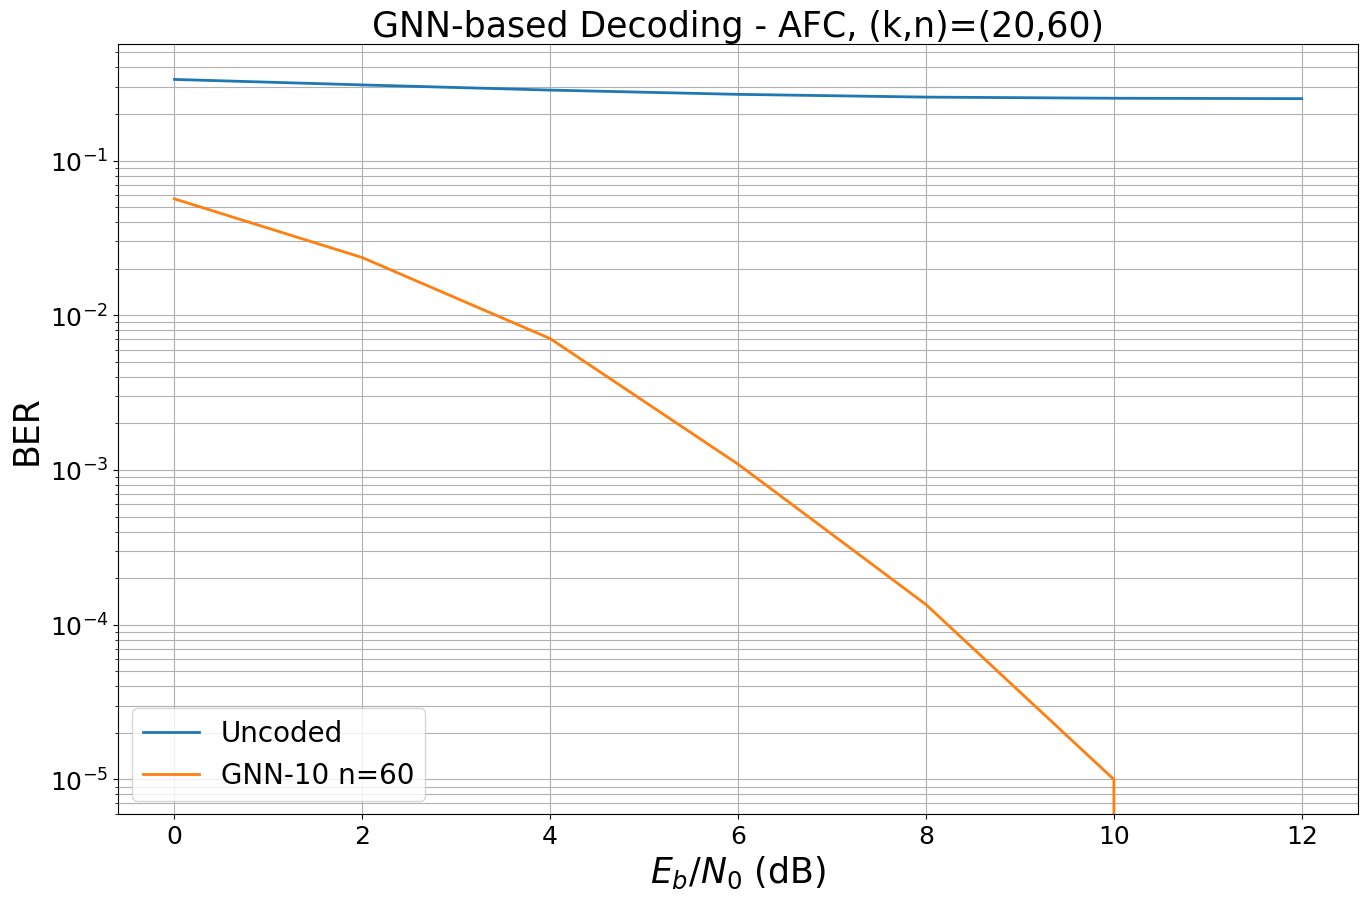

In [33]:
for n_eval in params["eval_ns"]:
    # generate new code for each length
    # pcm, k, n, coderate = generate_reg_ldpc(v=params["v"],
    #                                         c=params["c"],
    #                                         n=n_eval,
    #                                         allow_flex_len=True,
    #                                         verbose=False)

    # encoder = LinearEncoder(pcm, is_pcm=True)

    pcm, k, n, coderate = AFCEnc(k=params["k"],
                      w=params["w"],
                      n=n_eval)
    #encoder=check
    encoder = NonBinaryLinearEncoder(pcm, is_pcm=False)
    print('encoder:', encoder)
    

    # simulate "conventional" BP performance first
    # bp_decoder = LDPCBPDecoder(pcm,
    #                            num_iter=params["eval_dec_iter"],
    #                            hard_out=False)
    # e2e_bp = E2EModel(encoder, bp_decoder, k, n)
    # ber_plot.simulate(e2e_bp,
    #                   ebno_dbs=ebno_dbs,
    #                   batch_size=params["mc_batch_size"],
    #                   num_target_block_errors=params["num_target_block_errors"],
    #                   legend=f"BP-{bp_decoder._num_iter.numpy()} n={n}",
    #                   soft_estimates=True,
    #                   max_mc_iter=params["mc_iters"],
    #                   forward_keyboard_interrupt=False,
    #                   show_fig=False);

    # instantiate new decoder for each number of iter (otherwise no retracing)
    gnn_dec_temp = GNN_BP(pcm=pcm,
                          num_embed_dims=params["num_embed_dims"],
                          num_msg_dims=params["num_msg_dims"],
                          num_hidden_units=params["num_hidden_units"],
                          num_mlp_layers=params["num_mlp_layers"],
                          num_iter=params["eval_dec_iter"],
                          reduce_op=params["reduce_op"],
                          activation=params["activation"],
                          output_all_iter=False,
                          clip_llr_to=params["clip_llr_to"],
                          use_attributes=params["use_attributes"],
                          node_attribute_dims=params["node_attribute_dims"],
                          msg_attribute_dims=params["msg_attribute_dims"],
                          use_bias=params["use_bias"])
    # generate new model
    model = E2EModel(encoder, gnn_dec_temp, k, n)
    model(1,1.) # init model
    # copy weights from trained decoder
    model._decoder.set_weights(gnn_decoder.get_weights())

    # and run the BER simulations
    ber_plot.simulate(model,
                     ebno_dbs=ebno_dbs,
                     batch_size=params["mc_batch_size"],
                     num_target_block_errors=params[ "num_target_block_errors"],
                     legend=f"GNN-{params['eval_dec_iter']} n={n_eval}",
                     soft_estimates=True,
                     max_mc_iter=params["mc_iters"],
                     forward_keyboard_interrupt=False,
                     show_fig=True);
#ber_plot(xlim=[10,20], ylim=[1e-5,0.1]) #show final figure
#ber_plot.save_fig('fig/simulation1.png')


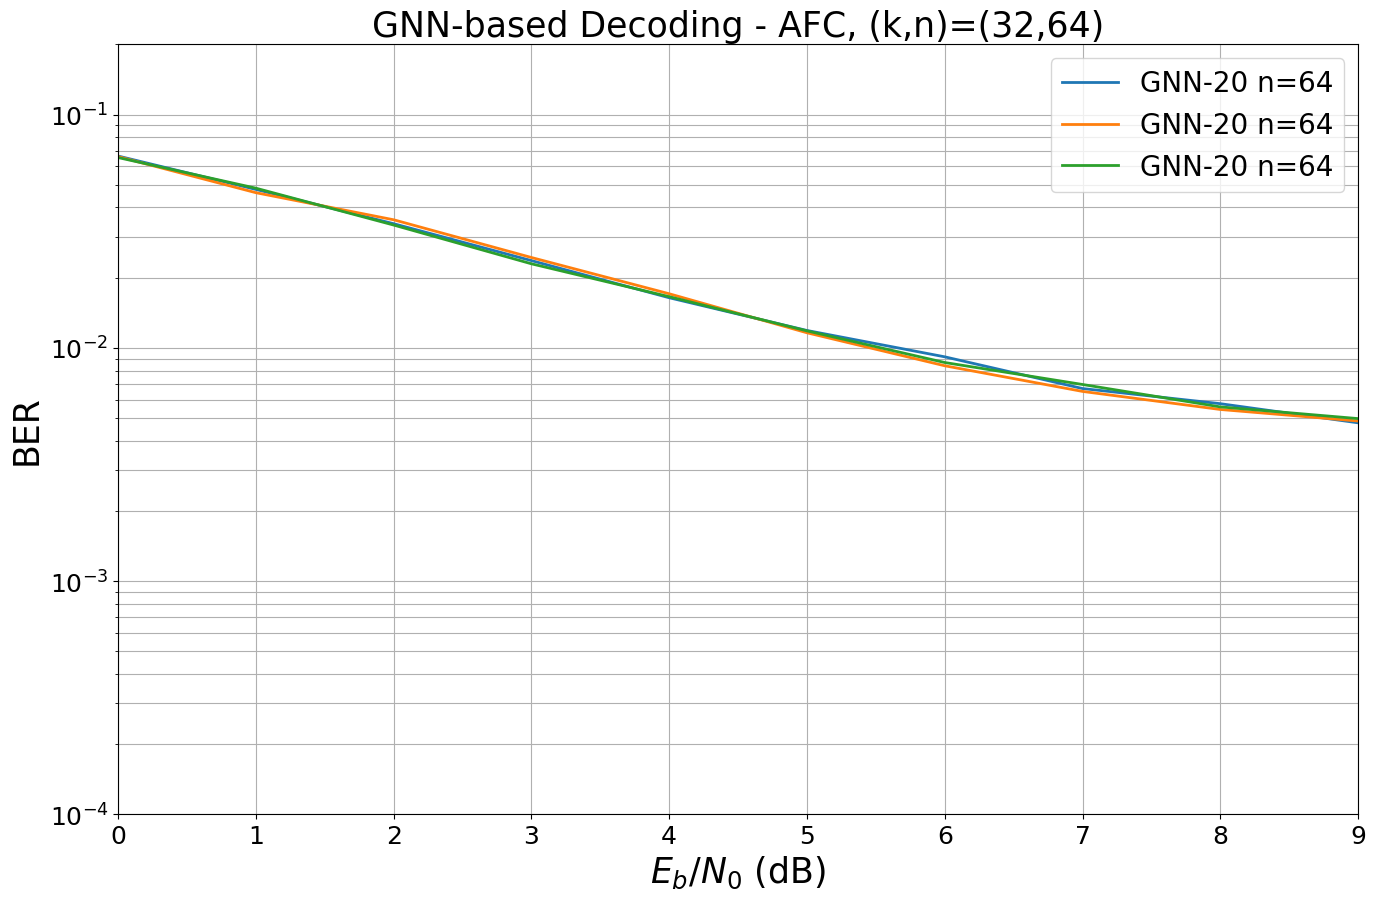

In [ ]:
ber_plot(xlim=[0, 9], ylim=[1e-4, 0.2]) # show final figure

*Remark*: as we use a non-optimized random LDPC code construction, the resulting LDPC code has a significant error-floor.
This is an artefact of the code construction method and not a related to the decoder itself.